### Multi step model (simple encoder-decoder)

In this notebook, we demonstrate how to:
- prepare time series data for training a RNN forecasting model
- get data in the required shape for the keras API
- implement a RNN model in keras to predict the next 3 steps ahead (time *t+1* to *t+3*) in the time series. This model uses a simple encoder decoder approach in which the final hidden state of the encoder is replicated across each time step of the decoder. 
- enable early stopping to reduce the likelihood of model overfitting
- evaluate the model on a test dataset

The data in this example is taken from the GEFCom2014 forecasting competition<sup>1</sup>. It consists of 3 years of hourly electricity load and temperature values between 2012 and 2014. The task is to forecast future values of electricity load.

<sup>1</sup>Tao Hong, Pierre Pinson, Shu Fan, Hamidreza Zareipour, Alberto Troccoli and Rob J. Hyndman, "Probabilistic energy forecasting: Global Energy Forecasting Competition 2014 and beyond", International Journal of Forecasting, vol.32, no.3, pp 896-913, July-September, 2016.

In [92]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from collections import UserDict
from IPython.display import Image
%matplotlib inline

from common.utils import load_data, mape, TimeSeriesTensor, create_evaluation_df

pd.options.display.float_format = '{:,.20f}'.format
np.set_printoptions(precision=20)
warnings.filterwarnings("ignore")

In [93]:
df = pd.read_csv("Cleaned1.csv" , parse_dates = True)
a = pd.to_datetime(df['Epoch_Time_of_Clock'])
print(type(a[0]))
df = df.drop(['Unnamed: 0', 'Unnamed: 0.1'  ,'e' ,'PRN','SV_Clock_Bias', 'SV_Clock_Drift', 'SV_Clock_Drift_Rate', 'IODE', 'Crs',
       'OMEGA', 'i0', 'Cuc','Toe', 'Cic', 'omega',
       'Cis', 'M0', 'I_dot', 'Codes', 'GPS_week',
       'L2_P_Data_flag', 'SV_accuracy', 'SV_health', 'Tgd', 'IODC', 'T_Tx',
       'Fit_Interval' ,'Epoch_Time_of_Clock' ],axis =1 )
df.head()
#df = df.set_index(['Epoch_Time_of_Clock'])
df = df.set_index(a)
df.head()

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


,Del_n,Cus,sqrt_A,Crc,OMEGA_dot
Epoch_Time_of_Clock,,,,,
2017-11-01 14:00:00,0.00000000487484591404,0.00000387243926525000,"5,153.67019652999988466036",309.37500000000000000000,-0.00000000826677291570
2017-11-01 16:00:00,0.00000000491699052668,0.00000384263694286000,"5,153.66918755000006058253",310.12500000000000000000,-0.00000000835070498324
2017-11-01 18:00:00,0.00000000487484591404,0.00000376440584660000,"5,153.66988753999976324849",308.62500000000000000000,-0.00000000838070623291
2017-11-01 20:00:00,0.00000000487520307178,0.00000389851629734000,"5,153.67030524999972840305",309.37500000000000000000,-0.00000000849213944598
2017-11-01 22:00:00,0.00000000475305512668,0.00000398606061935000,"5,153.67324066000037419144",307.43750000000000000000,-0.00000000843142263117


In [94]:
var_name = 'OMEGA_dot'
sat_var = 1

In [95]:

df = df.iloc[5 : , :]

In [96]:

df.columns

Index(['Del_n', 'Cus', 'sqrt_A', 'Crc', 'OMEGA_dot'], dtype='object')

# Enter number of entries per day

In [97]:
entry = 6
print(df.shape[0])
no_of_entries = df.shape[0]//entry
valid = (no_of_entries * 70)//100
test = (no_of_entries * 85)//100
indexes = df.index
#print(valid , test , indexes)
valid_start_dt = indexes[int(valid)*int(entry)] 
test_start_dt = indexes [int(test)*int(entry)] 
test_start_dt = str(test_start_dt)
valid_start_dt = str(valid_start_dt)
print(test_start_dt,valid_start_dt)
print(type(test_start_dt))

168
2017-11-25 12:00:00 2017-11-21 12:00:00
<class 'str'>



Load data into Pandas dataframe

# enter lag and no. of outputs

In [98]:
"""total = len(df)
t = total*70/100
t = round(t)
indexes = df.index
valid_start_dt = str(indexes[t])
t = total*85/100
t = round(t)
test_start_dt = str(indexes[t])
print(valid_start_dt , test_start_dt)
"""
T = 6
HORIZON = 6

Create training set containing only the model features

In [99]:
train = df.copy()[df.index < valid_start_dt][['Del_n', 'Cus', 'sqrt_A', 'Crc', 'OMEGA_dot' ]]
train.head()

,Del_n,Cus,sqrt_A,Crc,OMEGA_dot
Epoch_Time_of_Clock,,,,,
2017-11-02 12:00:00,0.00000000491949063082,0.00000451132655144000,"5,153.67212868000024172943",297.03125000000000000000,-0.00000000839749264642
2017-11-02 14:00:00,0.00000000485198781905,0.00000493414700031000,"5,153.66936874000020907260",288.65625000000000000000,-0.00000000818891252965
2017-11-02 16:00:00,0.00000000489056085435,0.00000489875674248000,"5,153.66863631999967765296",289.53125000000000000000,-0.00000000828213069827
2017-11-02 18:00:00,0.00000000486627412842,0.00000469386577606000,"5,153.66860771000028762501",290.93750000000000000000,-0.00000000832034657583
2017-11-02 20:00:00,0.00000000486484549748,0.00000475533306599000,"5,153.66959381000015127938",293.37500000000000000000,-0.00000000844856620241


In [100]:
train.tail(6)

,Del_n,Cus,sqrt_A,Crc,OMEGA_dot
Epoch_Time_of_Clock,,,,,
2017-11-20 12:00:00,0.00000000421588989445,0.00001104921102520000,"5,153.67980194000028859591",169.65625000000000000000,-0.00000000761960310134
2017-11-20 14:00:00,0.00000000416088760338,0.00001117587089540000,"5,153.68068503999984386610",168.31250000000000000000,-0.00000000760888836931
2017-11-20 16:00:00,0.00000000420196074282,0.00001054815948010000,"5,153.67795372000000497792",179.53125000000000000000,-0.00000000763460372618
2017-11-20 18:00:00,0.00000000418624580251,0.00001023523509500000,"5,153.68110084999989339849",187.56250000000000000000,-0.00000000780496796539
2017-11-20 20:00:00,0.00000000416624496940,0.00001030042767520000,"5,153.67985152999972342514",188.25000000000000000000,-0.00000000778639576321
2017-11-20 22:00:00,0.00000000407731269358,0.00001066923141480000,"5,153.68220519999977113912",178.34375000000000000000,-0.00000000775568019807


Scale data to be in range (0, 1). This transformation should be calibrated on the training set only. This is to prevent information from the validation or test sets leaking into the training data.

# Enter variable to be predicted

In [101]:
from sklearn.preprocessing import StandardScaler



y_scalar = StandardScaler()
y_scalar.fit(train[[var_name]])


X_scaler = StandardScaler()
train[['Del_n', 'Cus', 'sqrt_A', 'Crc', 'OMEGA_dot']] = X_scaler.fit_transform(train)

Use the TimeSeriesTensor convenience class to:
1. Shift the values of the time series to create a Pandas dataframe containing all the data for a single training example
2. Discard any samples with missing values
3. Transform this Pandas dataframe into a numpy array of shape (samples, time steps, features) for input into Keras

The class takes the following parameters:

- **dataset**: original time series
- **H**: the forecast horizon
- **tensor_structure**: a dictionary discribing the tensor structure in the form { 'tensor_name' : (range(max_backward_shift, max_forward_shift), [feature, feature, ...] ) }
- **freq**: time series frequency
- **drop_incomplete**: (Boolean) whether to drop incomplete samples

In [102]:
tensor_structure = {'X':(range(-T+1, 1), ['Del_n', 'Cus', 'sqrt_A', 'Crc', 'OMEGA_dot'])}
train_inputs = TimeSeriesTensor(train, var_name, HORIZON, {'X':(range(-T+1, 1), ['Del_n', 'Cus', 'sqrt_A', 'Crc', 'OMEGA_dot'])} ,freq = None)

In [103]:
#train_inputs.dataframe

In [104]:
train_inputs['target'].shape

(103, 6)

Construct validation set (keeping T hours from the training set in order to construct initial features)

In [105]:
look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
valid = df.copy()[(df.index >=look_back_dt) & (df.index < test_start_dt)][['Del_n', 'Cus', 'sqrt_A', 'Crc', 'OMEGA_dot']]
valid[['Del_n', 'Cus', 'sqrt_A', 'Crc', 'OMEGA_dot']] = X_scaler.transform(valid)
valid_inputs = TimeSeriesTensor(valid, var_name, HORIZON, tensor_structure,freq = None)
valid_inputs.dataframe.head()

tensor                              target                         \
feature                                  y                          
time step                              t+1                    t+2   
Epoch_Time_of_Clock                                                 
2017-11-21 22:00:00 1.68158109707269565192 1.65430993250853264342   
2017-11-22 12:00:00 1.65430993250853264342 1.54362108807462417026   
2017-11-22 14:00:00 1.54362108807462417026 0.73992382634079278958   
2017-11-22 16:00:00 0.73992382634079278958 0.81050801697216345865   
2017-11-22 18:00:00 0.81050801697216345865 0.92600941984800633211   

tensor                                                             \
feature                                                             
time step                              t+3                    t+4   
Epoch_Time_of_Clock                                                 
2017-11-21 22:00:00 1.54362108807462417026 0.73992382634079278958   
2017-11-22 12:00:00 0.73992382634079278958 0.81050801697216345865   
2017-11-22 14:00:00 0.81050801697216345865 0.92600941984800633211   
2017-11-22 16:00:00 0.92600941984800633211 1.35272293608057303516   
2017-11-22 18:00:00 1.35272293608057303516 1.29336804851031295094   

tensor                                                             \
feature                                                             
time step                              t+5                    t+6   
Epoch_Time_of_Clock                                                 
2017-11-21 22:00:00 0.81050801697216345865 0.92600941984800633211   
2017-11-22 12:00:00 0.92600941984800633211 1.35272293608057303516   
2017-11-22 14:00:00 1.35272293608057303516 1.29336804851031295094   
2017-11-22 16:00:00 1.29336804851031295094 1.19872106557945667937   
2017-11-22 18:00:00 1.19872106557945667937 0.43994101604517188431   

tensor                                    X                          \
feature                               Del_n                           
time step                               t-5                     t-4   
Epoch_Time_of_Clock                                                   
2017-11-21 22:00:00 -1.43868358391139095076 -1.63409748789003583802   
2017-11-22 12:00:00 -1.63409748789003583802 -1.43067481735893009542   
2017-11-22 14:00:00 -1.43067481735893009542 -1.41305553091661639797   
2017-11-22 16:00:00 -1.41305553091661639797 -1.54119579584563992647   
2017-11-22 18:00:00 -1.54119579584563992647 -1.89037801770324032091   

tensor                                                               ...  \
feature                                                              ...   
time step                               t-3                     t-2  ...   
Epoch_Time_of_Clock                                                  ...   
2017-11-21 22:00:00 -1.43067481735893009542 -1.41305553091661639797  ...   
2017-11-22 12:00:00 -1.41305553091661639797 -1.54119579584563992647  ...   
2017-11-22 14:00:00 -1.54119579584563992647 -1.89037801770324032091  ...   
2017-11-22 16:00:00 -1.89037801770324032091 -1.48673618322613831921  ...   
2017-11-22 18:00:00 -1.48673618322613831921 -1.61807995478512123277  ...   

tensor                                                               \
feature                                 Crc                           
time step                               t-3                     t-2   
Epoch_Time_of_Clock                                                   
2017-11-21 22:00:00 -1.11991269150023331491 -0.91234314935873250807   
2017-11-22 12:00:00 -0.91234314935873250807 -0.84113806370501376097   
2017-11-22 14:00:00 -0.84113806370501376097 -1.00974633256429102701   
2017-11-22 16:00:00 -1.00974633256429102701 -1.06953173466977191630   
2017-11-22 18:00:00 -1.06953173466977191630 -1.19581999979146158530   

tensor                                                               \
feature                                                               
time step                  

## Implement the RNN

We will implement a RNN forecasting model with the following structure:

In [106]:
#Image('./images/simple_encoder_decoder.png')

In [107]:
from keras.models import Model, Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Flatten
from keras.callbacks import EarlyStopping ,ModelCheckpoint

In [108]:
LATENT_DIM = 64
BATCH_SIZE = 32
EPOCHS = 1000

In [109]:
model = Sequential()
model.add(LSTM(LATENT_DIM, input_shape=(T,5) ,return_sequences=True))
model.add(LSTM(LATENT_DIM))
model.add(RepeatVector(HORIZON))
model.add(LSTM(LATENT_DIM, return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.add(Flatten())

In [110]:
model.compile(optimizer='RMSprop', loss='mse')

In [111]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 6, 64)             17920     
_________________________________________________________________
lstm_9 (LSTM)                (None, 64)                33024     
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 6, 64)             0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 6, 64)             33024     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 6, 1)              65        
_________________________________________________________________
flatten_4 (Flatten)          (None, 6)                 0         
Total params: 84,033
Trainable params: 84,033
Non-trainable params: 0
_________________________________________________________________


In [119]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=500)

In [120]:
best_val = ModelCheckpoint(str(sat_var) +'_' +  var_name + '_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)

In [121]:
history = model.fit(train_inputs['X'],
          train_inputs['target'],
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(valid_inputs['X'], valid_inputs['target']),
          callbacks=[earlystop ,best_val],
          verbose=1 , shuffle = False)

Train on 103 samples, validate on 13 samples
Epoch 1/1000
103/103 [==============================] - 0s 866us/step - loss: 0.0136 - val_loss: 0.0590
Epoch 2/1000
103/103 [==============================] - 0s 849us/step - loss: 0.0244 - val_loss: 0.0288
Epoch 3/1000
103/103 [==============================] - 0s 919us/step - loss: 0.0086 - val_loss: 0.0401
Epoch 4/1000
103/103 [==============================] - 0s 1ms/step - loss: 0.0059 - val_loss: 0.0331
Epoch 5/1000
103/103 [==============================] - 0s 813us/step - loss: 0.0063 - val_loss: 0.0295
Epoch 6/1000
103/103 [==============================] - 0s 1ms/step - loss: 0.0080 - val_loss: 0.0301
Epoch 7/1000
103/103 [==============================] - 0s 1ms/step - loss: 0.0086 - val_loss: 0.0328
Epoch 8/1000
103/103 [==============================] - 0s 1ms/step - loss: 0.0070 - val_loss: 0.0245
Epoch 9/1000
103/103 [==============================] - 0s 918us/step - loss: 0.0129 - val_loss: 0.0311
Epoch 10/1000
103/103 [====

103/103 [==============================] - 0s 1ms/step - loss: 0.0092 - val_loss: 0.0432
Epoch 80/1000
103/103 [==============================] - 0s 831us/step - loss: 0.0036 - val_loss: 0.0342
Epoch 81/1000
103/103 [==============================] - 0s 861us/step - loss: 0.0036 - val_loss: 0.0458
Epoch 82/1000
103/103 [==============================] - 0s 2ms/step - loss: 0.0082 - val_loss: 0.0295
Epoch 83/1000
103/103 [==============================] - 0s 1ms/step - loss: 0.0073 - val_loss: 0.0637
Epoch 84/1000
103/103 [==============================] - 0s 689us/step - loss: 0.0044 - val_loss: 0.0543
Epoch 85/1000
103/103 [==============================] - 0s 661us/step - loss: 0.0078 - val_loss: 0.0554
Epoch 86/1000
103/103 [==============================] - 0s 656us/step - loss: 0.0080 - val_loss: 0.0376
Epoch 87/1000
103/103 [==============================] - 0s 696us/step - loss: 0.0044 - val_loss: 0.0490
Epoch 88/1000
103/103 [==============================] - 0s 690us/step - lo

Epoch 157/1000
103/103 [==============================] - 0s 725us/step - loss: 0.0027 - val_loss: 0.0538
Epoch 158/1000
103/103 [==============================] - 0s 666us/step - loss: 0.0050 - val_loss: 0.0756
Epoch 159/1000
103/103 [==============================] - 0s 671us/step - loss: 0.0098 - val_loss: 0.0919
Epoch 160/1000
103/103 [==============================] - 0s 671us/step - loss: 0.0064 - val_loss: 0.0671
Epoch 161/1000
103/103 [==============================] - 0s 672us/step - loss: 0.0045 - val_loss: 0.0860
Epoch 162/1000
103/103 [==============================] - 0s 697us/step - loss: 0.0038 - val_loss: 0.0639
Epoch 163/1000
103/103 [==============================] - 0s 581us/step - loss: 0.0040 - val_loss: 0.0724
Epoch 164/1000
103/103 [==============================] - 0s 676us/step - loss: 0.0046 - val_loss: 0.0389
Epoch 165/1000
103/103 [==============================] - 0s 673us/step - loss: 0.0029 - val_loss: 0.0410
Epoch 166/1000
103/103 [======================

103/103 [==============================] - 0s 740us/step - loss: 0.0051 - val_loss: 0.0339
Epoch 235/1000
103/103 [==============================] - 0s 677us/step - loss: 0.0046 - val_loss: 0.0603
Epoch 236/1000
103/103 [==============================] - 0s 660us/step - loss: 0.0044 - val_loss: 0.0577
Epoch 237/1000
103/103 [==============================] - 0s 678us/step - loss: 0.0053 - val_loss: 0.0887
Epoch 238/1000
103/103 [==============================] - 0s 692us/step - loss: 0.0045 - val_loss: 0.0711
Epoch 239/1000
103/103 [==============================] - 0s 681us/step - loss: 0.0037 - val_loss: 0.0963
Epoch 240/1000
103/103 [==============================] - 0s 674us/step - loss: 0.0038 - val_loss: 0.0735
Epoch 241/1000
103/103 [==============================] - 0s 656us/step - loss: 0.0035 - val_loss: 0.0750
Epoch 242/1000
103/103 [==============================] - 0s 707us/step - loss: 0.0050 - val_loss: 0.0322
Epoch 243/1000
103/103 [==============================] - 0s 

103/103 [==============================] - 0s 761us/step - loss: 0.0039 - val_loss: 0.0942
Epoch 312/1000
103/103 [==============================] - 0s 637us/step - loss: 0.0029 - val_loss: 0.0633
Epoch 313/1000
103/103 [==============================] - 0s 682us/step - loss: 0.0025 - val_loss: 0.0645
Epoch 314/1000
103/103 [==============================] - 0s 662us/step - loss: 0.0049 - val_loss: 0.0386
Epoch 315/1000
103/103 [==============================] - 0s 684us/step - loss: 0.0034 - val_loss: 0.0629
Epoch 316/1000
103/103 [==============================] - 0s 545us/step - loss: 0.0038 - val_loss: 0.0414
Epoch 317/1000
103/103 [==============================] - 0s 654us/step - loss: 0.0059 - val_loss: 0.0567
Epoch 318/1000
103/103 [==============================] - 0s 627us/step - loss: 0.0047 - val_loss: 0.0419
Epoch 319/1000
103/103 [==============================] - 0s 696us/step - loss: 0.0032 - val_loss: 0.0750
Epoch 320/1000
103/103 [==============================] - 0s 

103/103 [==============================] - 0s 930us/step - loss: 0.0045 - val_loss: 0.0339
Epoch 389/1000
103/103 [==============================] - 0s 920us/step - loss: 0.0015 - val_loss: 0.0579
Epoch 390/1000
103/103 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0573
Epoch 391/1000
103/103 [==============================] - 0s 1ms/step - loss: 0.0034 - val_loss: 0.0958
Epoch 392/1000
103/103 [==============================] - 0s 763us/step - loss: 0.0039 - val_loss: 0.0877
Epoch 393/1000
103/103 [==============================] - 0s 850us/step - loss: 0.0046 - val_loss: 0.0923
Epoch 394/1000
103/103 [==============================] - 0s 714us/step - loss: 0.0042 - val_loss: 0.0587
Epoch 395/1000
103/103 [==============================] - 0s 748us/step - loss: 0.0039 - val_loss: 0.0859
Epoch 396/1000
103/103 [==============================] - 0s 695us/step - loss: 0.0021 - val_loss: 0.0529
Epoch 397/1000
103/103 [==============================] - 0s 658u

103/103 [==============================] - 0s 748us/step - loss: 0.0018 - val_loss: 0.0643
Epoch 466/1000
103/103 [==============================] - 0s 700us/step - loss: 0.0034 - val_loss: 0.0545
Epoch 467/1000
103/103 [==============================] - 0s 684us/step - loss: 0.0045 - val_loss: 0.1159
Epoch 468/1000
103/103 [==============================] - 0s 649us/step - loss: 0.0060 - val_loss: 0.0720
Epoch 469/1000
103/103 [==============================] - 0s 678us/step - loss: 0.0038 - val_loss: 0.0843
Epoch 470/1000
103/103 [==============================] - 0s 662us/step - loss: 0.0029 - val_loss: 0.0590
Epoch 471/1000
103/103 [==============================] - 0s 645us/step - loss: 0.0019 - val_loss: 0.0674
Epoch 472/1000
103/103 [==============================] - 0s 708us/step - loss: 0.0017 - val_loss: 0.0497
Epoch 473/1000
103/103 [==============================] - 0s 694us/step - loss: 0.0032 - val_loss: 0.0515
Epoch 474/1000
103/103 [==============================] - 0s 

103/103 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0465
Epoch 543/1000
103/103 [==============================] - 0s 2ms/step - loss: 8.9971e-04 - val_loss: 0.0601
Epoch 544/1000
103/103 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0608
Epoch 545/1000
103/103 [==============================] - 0s 581us/step - loss: 0.0034 - val_loss: 0.0858
Epoch 546/1000
103/103 [==============================] - 0s 749us/step - loss: 0.0021 - val_loss: 0.0641
Epoch 547/1000
103/103 [==============================] - 0s 698us/step - loss: 0.0029 - val_loss: 0.0796
Epoch 548/1000
103/103 [==============================] - 0s 1ms/step - loss: 0.0032 - val_loss: 0.0448
Epoch 549/1000
103/103 [==============================] - 0s 2ms/step - loss: 0.0045 - val_loss: 0.0761
Epoch 550/1000
103/103 [==============================] - 0s 1ms/step - loss: 0.0037 - val_loss: 0.0757
Epoch 551/1000
103/103 [==============================] - 0s 896us/st

In [122]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model.load_weights(str(sat_var) +'_' +  var_name + '_{:02d}.h5'.format(best_epoch))

In [124]:
model.fit(valid_inputs['X'],
          valid_inputs['target'],
          batch_size=BATCH_SIZE,
          epochs=100,
          callbacks=[earlystop ,best_val],
          verbose=1 , shuffle = False)

Epoch 1/100
13/13 [==============================] - 0s 1ms/step - loss: 0.0208
Epoch 2/100
13/13 [==============================] - 0s 1ms/step - loss: 0.1225
Epoch 3/100
13/13 [==============================] - 0s 1ms/step - loss: 0.0618
Epoch 4/100
13/13 [==============================] - 0s 1ms/step - loss: 0.0366
Epoch 5/100
13/13 [==============================] - 0s 1ms/step - loss: 0.0185
Epoch 6/100
13/13 [==============================] - 0s 1ms/step - loss: 0.0115
Epoch 7/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0058
Epoch 8/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0046
Epoch 9/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0040
Epoch 10/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 11/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0032
Epoch 12/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0030
Epoch 13/100
13/13 [=================

## Evaluate the model

In [125]:
look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
test = df.copy()[test_start_dt:][['Del_n', 'Cus', 'sqrt_A', 'Crc', 'OMEGA_dot']]
test[['Del_n', 'Cus', 'sqrt_A', 'Crc', 'OMEGA_dot']] = X_scaler.transform(test)
test_inputs = TimeSeriesTensor(test, var_name, HORIZON, tensor_structure,freq =None)
test_inputs.dataframe.head()

tensor                               target                          \
feature                                   y                           
time step                               t+1                     t+2   
Epoch_Time_of_Clock                                                   
2017-11-25 22:00:00 -0.08302366920567914865 -0.26429670431587648505   
2017-11-26 12:00:00 -0.26429670431587648505 -0.32846415037298160033   
2017-11-26 14:00:00 -0.32846415037298160033 -0.87709581405565684165   
2017-11-26 16:00:00 -0.87709581405565684165 -0.81132418186622035083   
2017-11-26 18:00:00 -0.81132418186622035083 -0.75678185273789455589   

tensor                                                               \
feature                                                               
time step                               t+3                     t+4   
Epoch_Time_of_Clock                                                   
2017-11-25 22:00:00 -0.32846415037298160033 -0.87709581405565684165   
2017-11-26 12:00:00 -0.87709581405565684165 -0.81132418186622035083   
2017-11-26 14:00:00 -0.81132418186622035083 -0.75678185273789455589   
2017-11-26 16:00:00 -0.75678185273789455589 -0.42150694712658837160   
2017-11-26 18:00:00 -0.42150694712658837160 -0.66213486980703839535   

tensor                                                               \
feature                                                               
time step                               t+5                     t+6   
Epoch_Time_of_Clock                                                   
2017-11-25 22:00:00 -0.81132418186622035083 -0.75678185273789455589   
2017-11-26 12:00:00 -0.75678185273789455589 -0.42150694712658837160   
2017-11-26 14:00:00 -0.42150694712658837160 -0.66213486980703839535   
2017-11-26 16:00:00 -0.66213486980703839535 -0.73913580505758535999   
2017-11-26 18:00:00 -0.73913580505758535999 -1.26691304879528887639   

tensor                                    X                          \
feature                               Del_n                           
time step                               t-5                     t-4   
Epoch_Time_of_Clock                                                   
2017-11-25 22:00:00 -0.46962283052577807885 -0.39273867158629655050   
2017-11-26 12:00:00 -0.39273867158629655050 -0.47923335037078829135   
2017-11-26 14:00:00 -0.47923335037078829135 -0.34148256559675088662   
2017-11-26 16:00:00 -0.34148256559675088662 -0.65542621465940897885   
2017-11-26 18:00:00 -0.65542621465940897885 -0.59936484874735451722   

tensor                                                               ...  \
feature                                                              ...   
time step                               t-3                     t-2  ...   
Epoch_Time_of_Clock                                                  ...   
2017-11-25 22:00:00 -0.47923335037078829135 -0.34148256559675088662  ...   
2017-11-26 12:00:00 -0.34148256559675088662 -0.65542621465940897885  ...   
2017-11-26 14:00:00 -0.65542621465940897885 -0.59936484874735451722  ...   
2017-11-26 16:00:00 -0.59936484874735451722  0.07657504864786630894  ...   
2017-11-26 18:00:00  0.07657504864786630894  0.20311356023949428407  ...   

tensor                                                             \
feature                                Crc                          
time step                              t-3                    t-2   
Epoch_Time_of_Clock                                                 
2017-11-25 22:00:00 0.27463219356693691076 0.37337886895464111880   
2017-11-26 12:00:00 0.37337886895464111880 0.52855221599246204889   
2017-11-26 14:00:00 0.52855221599246204889 0.70992366058212297286   
2017-11-26 16:00:00 0.70992366058212297286 0.89935605826465758739   
2017-11-26 18:00:00 0.89935605826465758739 0.79859414460373490119   

tensor                                                             \
feature                                                         

In [126]:
test_inputs.dataframe.head(50)

tensor                               target                          \
feature                                   y                           
time step                               t+1                     t+2   
Epoch_Time_of_Clock                                                   
2017-11-25 22:00:00 -0.08302366920567914865 -0.26429670431587648505   
2017-11-26 12:00:00 -0.26429670431587648505 -0.32846415037298160033   
2017-11-26 14:00:00 -0.32846415037298160033 -0.87709581405565684165   
2017-11-26 16:00:00 -0.87709581405565684165 -0.81132418186622035083   
2017-11-26 18:00:00 -0.81132418186622035083 -0.75678185273789455589   
2017-11-26 20:00:00 -0.75678185273789455589 -0.42150694712658837160   
2017-11-26 22:00:00 -0.42150694712658837160 -0.66213486980703839535   
2017-11-27 12:00:00 -0.66213486980703839535 -0.73913580505758535999   
2017-11-27 14:00:00 -0.73913580505758535999 -1.26691304879528887639   
2017-11-27 16:00:00 -1.26691304879528887639 -1.15782839053864461398   
2017-11-27 18:00:00 -1.15782839053864461398 -1.07120233835930345201   
2017-11-27 20:00:00 -1.07120233835930345201 -0.53700835000242375106   
2017-11-27 22:00:00 -0.53700835000242375106 -0.83859534643038335933   
2017-11-28 12:00:00 -0.83859534643038335933 -0.94447163242235010472   
2017-11-28 14:00:00 -0.94447163242235010472 -1.49791585459187781559   
2017-11-28 16:00:00 -1.49791585459187781559 -1.32305956410087155461   
2017-11-28 18:00:00 -1.32305956410087155461 -1.18349536892555073919   
2017-11-28 20:00:00 -1.18349536892555073919 -0.36536043182100569338   
2017-11-28 22:00:00 -0.36536043182100569338 -0.71667719893535675180   

tensor                                                               \
feature                                                               
time step                               t+3                     t+4   
Epoch_Time_of_Clock                                                   
2017-11-25 22:00:00 -0.32846415037298160033 -0.87709581405565684165   
2017-11-26 12:00:00 -0.87709581405565684165 -0.81132418186622035083   
2017-11-26 14:00:00 -0.81132418186622035083 -0.75678185273789455589   
2017-11-26 16:00:00 -0.75678185273789455589 -0.42150694712658837160   
2017-11-26 18:00:00 -0.42150694712658837160 -0.66213486980703839535   
2017-11-26 20:00:00 -0.66213486980703839535 -0.73913580505758535999   
2017-11-26 22:00:00 -0.73913580505758535999 -1.26691304879528887639   
2017-11-27 12:00:00 -1.26691304879528887639 -1.15782839053864461398   
2017-11-27 14:00:00 -1.15782839053864461398 -1.07120233835930345201   
2017-11-27 16:00:00 -1.07120233835930345201 -0.53700835000242375106   
2017-11-27 18:00:00 -0.53700835000242375106 -0.83859534643038335933   
2017-11-27 20:00:00 -0.83859534643038335933 -0.94447163242235010472   
2017-11-27 22:00:00 -0.94447163242235010472 -1.49791585459187781559   
2017-11-28 12:00:00 -1.49791585459187781559 -1.32305956410087155461   
2017-11-28 14:00:00 -1.32305956410087155461 -1.18349536892555073919   
2017-11-28 16:00:00 -1.18349536892555073919 -0.36536043182100569338   
2017-11-28 18:00:00 -0.36536043182100569338 -0.71667719893535675180   
2017-11-28 20:00:00 -0.71667719893535675180 -0.85624139411067756722   
2017-11-28 22:00:00 -0.85624139411067756722 -1.47866562077924457164   

tensor                                                               \
feature                                                               
time step                               t+5                     t+6   
Epoch_Time_of_Clock                                                   
2017-11-25 22:00:00 -0.81132418186622035083 -0.75678185273789455589   
2017-11-26 12:00:00 -0.75678185273789455589 -0.42150694712658837160   
2017-11-26 14:00:00 -0.42150694712658837160 -0.66213486980703839535   
2017-11-26 16:00:00 -0.66213486980703839535 -0.73913580505758535999   
2017-11-26 18:00:00 -0.73913580505758535999 -1.26691304879528887639   
2017-11-26 20:00:00 -1.26691304879528887639 -1.15782839053864461398   
2017-11-26 22:00:00 -1

In [127]:
test_inputs.dataframe.shape

(19, 36)

In [128]:
predictions = model.predict(test_inputs['X'])

In [129]:
predictions

array([[-0.031763002, -0.11710991 , -0.41730446 , -0.90459347 ,
        -0.89281183 , -0.643763   ],
       [-0.1386549  , -0.39251626 , -0.8045937  , -0.96378136 ,
        -0.7410399  , -0.42014718 ],
       [-0.379624   , -0.7069001  , -0.9379312  , -0.8277328  ,
        -0.55334586 , -0.43418175 ],
       [-0.77925736 , -0.83077675 , -0.6939968  , -0.49308133 ,
        -0.54321027 , -0.7256571  ],
       [-0.7283374  , -0.64207065 , -0.5820385  , -0.63402206 ,
        -0.8250493  , -1.0427042  ],
       [-0.5757264  , -0.5188341  , -0.6691359  , -0.9497264  ,
        -1.0945901  , -0.89411485 ],
       [-0.33366954 , -0.4657858  , -0.7953437  , -1.2154564  ,
        -1.1358901  , -0.8334595  ],
       [-0.4450696  , -0.7323377  , -1.1320943  , -1.2263902  ,
        -0.94344866 , -0.576315   ],
       [-0.6656056  , -0.99445045 , -1.1989169  , -1.0368716  ,
        -0.7083173  , -0.60363376 ],
       [-1.0208727  , -1.089477   , -0.9370807  , -0.6709142  ,
        -0.6779554  , -0.83

In [130]:
eval_df = create_evaluation_df(predictions, test_inputs, HORIZON, y_scalar)
print(eval_df.head())
print(eval_df.tail())
print(eval_df.shape)


            timestamp    h              prediction                  actual
0 2017-11-25 22:00:00  t+1 -0.00000000801892176551 -0.00000000803033449566
1 2017-11-26 12:00:00  t+1 -0.00000000804272029343 -0.00000000807069331963
2 2017-11-26 14:00:00  t+1 -0.00000000809636991511 -0.00000000808497962900
3 2017-11-26 16:00:00  t+1 -0.00000000818534471456 -0.00000000820712757409
4 2017-11-26 18:00:00  t+1 -0.00000000817400784199 -0.00000000819248410699
              timestamp    h              prediction                  actual
109 2017-11-28 14:00:00  t+6 -0.00000000814531445168 -0.00000000817141180067
110 2017-11-28 16:00:00  t+6 -0.00000000817216508182 -0.00000000820248452355
111 2017-11-28 18:00:00  t+6 -0.00000000820932965902 -0.00000000834106172442
112 2017-11-28 20:00:00  t+6 -0.00000000815904847042 -0.00000000828463080241
113 2017-11-28 22:00:00  t+6 -0.00000000812801820828 -0.00000000824034324337
(114, 4)


In [131]:
eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']
eval_df.groupby('h')['APE'].mean()

h
t+1   -0.00477433784738212977
t+2   -0.00419670884946418948
t+3   -0.00324340309959317676
t+4   -0.00296960326945073377
t+5   -0.00471258651572456413
t+6   -0.00679278727001576040
Name: APE, dtype: float64

# Predictions

In [132]:
mape(eval_df['prediction'], eval_df['actual'])
from sklearn.metrics import mean_absolute_error
a = mean_absolute_error(eval_df['prediction'], eval_df['actual'])
a

3.662188585405348e-11

Plot actuals vs predictions at each horizon for first week of the test period. As is to be expected, predictions for one step ahead (*t+1*) are more accurate than those for 2 or 3 steps ahead

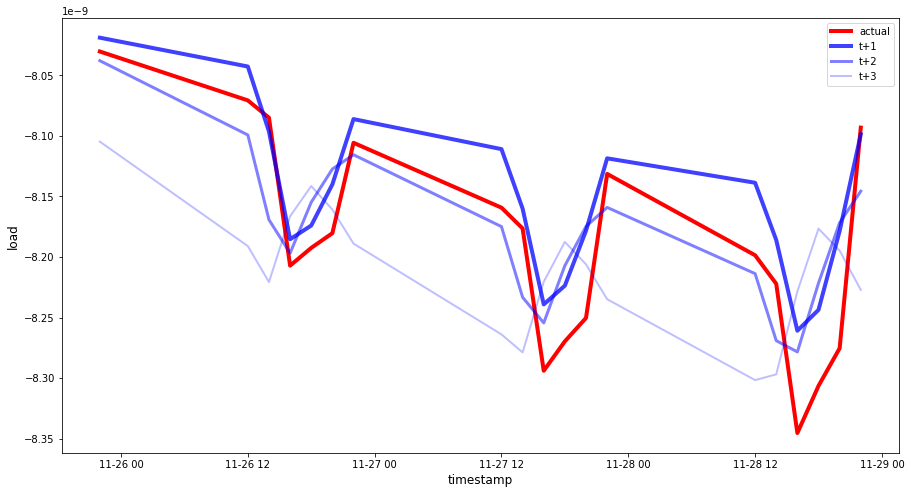

In [133]:
plot_df = eval_df[(eval_df.h=='t+1')][['timestamp', 'actual']]
for t in range(1, HORIZON+1):
    plot_df['t+'+str(t)] = eval_df[ (eval_df.h=='t+'+str(t))]['prediction'].values

fig = plt.figure(figsize=(15, 8))
ax = plt.plot(plot_df['timestamp'], plot_df['actual'], color='red', linewidth=4.0)
ax = fig.add_subplot(111)
ax.plot(plot_df['timestamp'], plot_df['t+1'], color='blue', linewidth=4.0, alpha=0.75)
ax.plot(plot_df['timestamp'], plot_df['t+2'], color='blue', linewidth=3.0, alpha=0.5)
ax.plot(plot_df['timestamp'], plot_df['t+3'], color='blue', linewidth=2.0, alpha=0.25)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
ax.legend(loc='best')
plt.show()

# take input here

In [134]:
a = df.iloc[156:162  , :]
a

,Del_n,Cus,sqrt_A,Crc,OMEGA_dot
Epoch_Time_of_Clock,,,,,
2017-11-28 12:00:00,0.00000000468162357984,0.00000496394932270000,"5,153.67251396000028762501",288.25000000000000000000,-0.00000000813141013444
2017-11-28 14:00:00,0.00000000471841082646,0.00000500492751598000,"5,153.67150496999965980649",287.78125000000000000000,-0.00000000819855578847
2017-11-28 16:00:00,0.00000000468769526132,0.00000502541661263000,"5,153.67233276000024488894",285.18750000000000000000,-0.00000000822212819893
2017-11-28 18:00:00,0.00000000469483841601,0.00000506825745106000,"5,153.67309189000025071437",286.96875000000000000000,-0.00000000834534761723
2017-11-28 20:00:00,0.00000000459626288137,0.00000505149364471000,"5,153.67578505999972549034",287.53125000000000000000,-0.00000000830641742420
2017-11-28 22:00:00,0.00000000458697678028,0.00000484287738800000,"5,153.67449759999999514548",290.46875000000000000000,-0.00000000827534470132


In [135]:
new_df = pd.DataFrame()

In [136]:
columns = ['Del_n', 'Cus', 'sqrt_A', 'Crc', 'OMEGA_dot'] 

In [137]:
for key , value in enumerate(columns):
    new_df[value] = a[value]

In [138]:
new_df = new_df.dropna( how = 'any')

In [139]:
new_df

,Del_n,Cus,sqrt_A,Crc,OMEGA_dot
Epoch_Time_of_Clock,,,,,
2017-11-28 12:00:00,0.00000000468162357984,0.00000496394932270000,"5,153.67251396000028762501",288.25000000000000000000,-0.00000000813141013444
2017-11-28 14:00:00,0.00000000471841082646,0.00000500492751598000,"5,153.67150496999965980649",287.78125000000000000000,-0.00000000819855578847
2017-11-28 16:00:00,0.00000000468769526132,0.00000502541661263000,"5,153.67233276000024488894",285.18750000000000000000,-0.00000000822212819893
2017-11-28 18:00:00,0.00000000469483841601,0.00000506825745106000,"5,153.67309189000025071437",286.96875000000000000000,-0.00000000834534761723
2017-11-28 20:00:00,0.00000000459626288137,0.00000505149364471000,"5,153.67578505999972549034",287.53125000000000000000,-0.00000000830641742420
2017-11-28 22:00:00,0.00000000458697678028,0.00000484287738800000,"5,153.67449759999999514548",290.46875000000000000000,-0.00000000827534470132


In [140]:
# creating index for output
import datetime
date = new_df.index.date[0]
date + datetime.timedelta(1)

datetime.date(2017, 11, 29)

In [141]:
import datetime
date = new_df.index + datetime.timedelta(days =1)

In [142]:
date

DatetimeIndex(['2017-11-29 12:00:00', '2017-11-29 14:00:00',
               '2017-11-29 16:00:00', '2017-11-29 18:00:00',
               '2017-11-29 20:00:00', '2017-11-29 22:00:00'],
              dtype='datetime64[ns]', name='Epoch_Time_of_Clock', freq='2H')

In [143]:
new_df.index= date

In [144]:
new_df.columns

Index(['Del_n', 'Cus', 'sqrt_A', 'Crc', 'OMEGA_dot'], dtype='object')

In [145]:
print(new_df)
print(new_df.columns)

                                     Del_n                    Cus  \
Epoch_Time_of_Clock                                                 
2017-11-29 12:00:00 0.00000000468162357984 0.00000496394932270000   
2017-11-29 14:00:00 0.00000000471841082646 0.00000500492751598000   
2017-11-29 16:00:00 0.00000000468769526132 0.00000502541661263000   
2017-11-29 18:00:00 0.00000000469483841601 0.00000506825745106000   
2017-11-29 20:00:00 0.00000000459626288137 0.00000505149364471000   
2017-11-29 22:00:00 0.00000000458697678028 0.00000484287738800000   

                                        sqrt_A                      Crc  \
Epoch_Time_of_Clock                                                       
2017-11-29 12:00:00 5,153.67251396000028762501 288.25000000000000000000   
2017-11-29 14:00:00 5,153.67150496999965980649 287.78125000000000000000   
2017-11-29 16:00:00 5,153.67233276000024488894 285.18750000000000000000   
2017-11-29 18:00:00 5,153.67309189000025071437 286.96875000000000000000 

In [146]:
freq = None
idx_tuples = []
drop_incomplete  = True
new_df[['Del_n', 'Cus', 'sqrt_A', 'Crc', 'OMEGA_dot']] = X_scaler.transform(new_df)
new_new_df = new_df.copy()
tensor_structure={'X':(range(-T+1, 1), ['Del_n', 'Cus', 'sqrt_A', 'Crc', 'OMEGA_dot'])}
for name, structure in tensor_structure.items():
        rng = structure[0]
        dataset_cols = structure[1]
        for col in dataset_cols:
        # do not shift non-sequential 'static' features
            if rng is None:
                new_df['context_'+col] = new_df[col]
                idx_tuples.append((name, col, 'static'))
            else:
                for t in rng:
                    sign = '+' if t > 0 else ''
                    shift = str(t) if t != 0 else ''
                    period = 't'+sign+shift
                    shifted_col = name+'_'+col+'_'+ period
                    new_new_df[shifted_col] = new_new_df[col].shift(t*-1, freq=freq)
                    idx_tuples.append((name, col, period))
        new_new_df = new_new_df.drop(new_df.columns, axis=1)
        idx = pd.MultiIndex.from_tuples(idx_tuples, names=['tensor', 'feature', 'time step'])
        print(new_df.head())
        new_new_df.columns = idx
        if drop_incomplete:
            new_new_df = new_new_df.dropna(how='any')
            
inputs = {}           
for name, structure in tensor_structure.items():
    rng = structure[0]
    cols = structure[1]
    tensor = new_new_df[name][cols].as_matrix()
    if rng is None:
        tensor = tensor.reshape(tensor.shape[0], len(cols))
    else:
        tensor = tensor.reshape(tensor.shape[0], len(cols), len(rng))
        tensor = np.transpose(tensor, axes=[0, 2, 1])
    inputs[name] = tensor

                                     Del_n                     Cus  \
Epoch_Time_of_Clock                                                  
2017-11-29 12:00:00 0.91269027718195072651 -1.22312509319444773226   
2017-11-29 14:00:00 1.07767086824331581596 -1.20617816297157554040   
2017-11-29 16:00:00 0.93992008346927835571 -1.19770469785600397472   
2017-11-29 18:00:00 0.97195514972395735676 -1.17998745262262549893   
2017-11-29 20:00:00 0.52987123577711836564 -1.18692028771718405267   

                                     sqrt_A                    Crc  \
Epoch_Time_of_Clock                                                  
2017-11-29 12:00:00 -0.90370805607990212227 1.22448116634390147262   
2017-11-29 14:00:00 -1.14731878453497881942 1.21440497497780919289   
2017-11-29 16:00:00 -0.94745701690112382742 1.15865004941876525990   
2017-11-29 18:00:00 -0.76417253223977721355 1.19693957660991601166   
2017-11-29 20:00:00 -0.11393307989914304434 1.20903100624922665851   

                  

In [147]:
print(new_new_df)
print(inputs['X'])

tensor                                   X                         \
feature                              Del_n                          
time step                              t-5                    t-4   
Epoch_Time_of_Clock                                                 
2017-11-29 22:00:00 0.91269027718195072651 1.07767086824331581596   

tensor                                                             \
feature                                                             
time step                              t-3                    t-2   
Epoch_Time_of_Clock                                                 
2017-11-29 22:00:00 0.93992008346927835571 0.97195514972395735676   

tensor                                                             \
feature                                                             
time step                              t-1                      t   
Epoch_Time_of_Clock                                                 
2017-11-29 22:00:00 0.5298712357

In [148]:
predictions = model.predict(inputs['X'])

In [149]:
predictions

array([[-0.3903802 , -0.60097617, -0.9670547 , -1.2216293 , -0.9747424 ,
        -0.5217734 ]], dtype=float32)

In [150]:
print(predictions.shape)


(1, 6)


In [151]:
results = predictions[-1, :]

In [152]:
results

array([-0.3903802 , -0.60097617, -0.9670547 , -1.2216293 , -0.9747424 ,
       -0.5217734 ], dtype=float32)

In [153]:
res_df = pd.DataFrame(results , columns = [var_name])
res_df

,OMEGA_dot
0,-0.39038020372390747070
1,-0.60097616910934448242
2,-0.96705472469329833984
3,-1.22162926197052001953
4,-0.97474241256713867188
5,-0.52177339792251586914


In [154]:
res_df.index = date
res_df

,OMEGA_dot
Epoch_Time_of_Clock,
2017-11-29 12:00:00,-0.39038020372390747070
2017-11-29 14:00:00,-0.60097616910934448242
2017-11-29 16:00:00,-0.96705472469329833984
2017-11-29 18:00:00,-1.22162926197052001953
2017-11-29 20:00:00,-0.97474241256713867188
2017-11-29 22:00:00,-0.52177339792251586914


In [155]:
res_df[var_name] = y_scalar.inverse_transform(res_df[[var_name]])    

# final generated output 

In [156]:
# final generated ouput
res_df

,OMEGA_dot
Epoch_Time_of_Clock,
2017-11-29 12:00:00,-0.00000000809876432584
2017-11-29 14:00:00,-0.00000000814565215279
2017-11-29 16:00:00,-0.00000000822715584547
2017-11-29 18:00:00,-0.00000000828383495133
2017-11-29 20:00:00,-0.00000000822886736529
2017-11-29 22:00:00,-0.00000000812801825845


In [57]:
res_df.to_csv('SA1_OMEGA_dot.csv')